In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
from sklearn.metrics import brier_score_loss
import seaborn as sns
import theano
import matplotlib.pyplot as plt
import joblib
%matplotlib inline

np.random.seed(13)

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
c:\python37\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
x = np.arange(-100, 101, 0.01)
y = np.zeros(x.shape)

In [3]:
x_shared = theano.shared(x)
y_shared = theano.shared(y)

In [4]:
model = pm.Model()

with model:
    x_0 = pm.Normal('x_0', mu=0, sigma=10)
    k = pm.Normal('k', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=1)

    mu = 1 / (1 + pm.math.exp(-k * (x_shared - x_0)))

    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=y_shared)

In [5]:
trace = pm.load_trace('bayes_wp_model.trace', model=model)

In [6]:
lr = joblib.load('lr_wp_model.joblib')

In [7]:
with model:
    post_pred = pm.sample_posterior_predictive(trace, samples=4000, random_seed=13)

In [8]:
y_bayes = post_pred['Y_obs'].mean(axis=0).clip(0, 1)

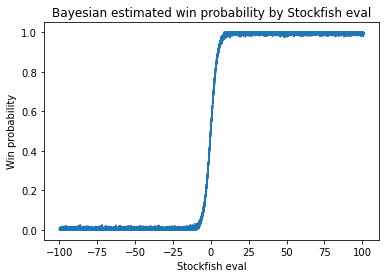

In [9]:
plt.plot(x, y_bayes)
plt.title('Bayesian estimated win probability by Stockfish eval')
plt.xlabel('Stockfish eval')
plt.ylabel('Win probability');

In [10]:
y_lr = lr.predict_proba(x.reshape(-1, 1)) @ np.array([0, 0.5, 1])

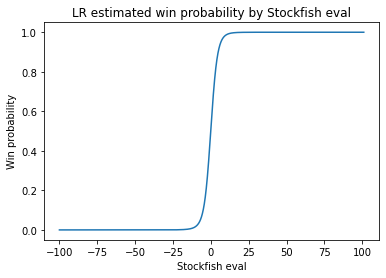

In [11]:
plt.plot(x, y_lr)
plt.title('LR estimated win probability by Stockfish eval')
plt.xlabel('Stockfish eval')
plt.ylabel('Win probability');

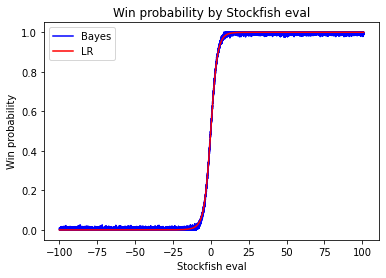

In [12]:
plt.plot(x, y_bayes, color='b', label='Bayes')
plt.plot(x, y_lr, color='r', label='LR')
plt.title('Win probability by Stockfish eval')
plt.xlabel('Stockfish eval')
plt.ylabel('Win probability')
plt.legend(loc='best');

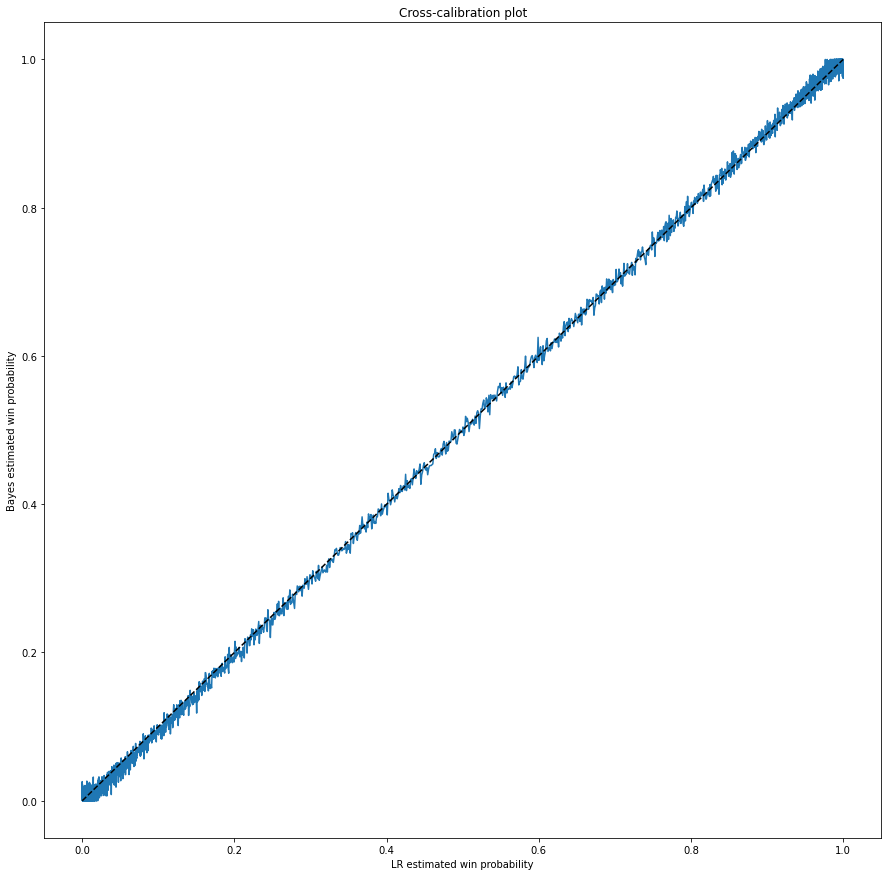

In [13]:
# where do the models disagree?

plt.figure(figsize=(15, 15))
plt.plot(y_lr, y_bayes)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('LR estimated win probability')
plt.ylabel('Bayes estimated win probability')
plt.title('Cross-calibration plot');

In [14]:
brier_score_loss(y_lr.round(), y_bayes), brier_score_loss(y_bayes.round(), y_lr)

(0.004241855197688784, 0.004288335658691523)

In [15]:
np.abs(y_lr - y_bayes).max()

0.03210848879652137

In [16]:
df = pd.DataFrame([x, y_lr, y_bayes]).T
df.columns = ['x', 'y_lr', 'y_bayes']
df.to_csv('../content/win_probabilities.csv', index=None)